In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import random
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F
import math
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_6/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_6/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float64)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[1][0]/3.1415926
            Y = Y - 0.5
            
            Y = torch.tensor( Y, dtype=torch.float64 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y
    
all_ids = [str(i) for i in  list(np.arange(0,10000,1))]
#train_ids = all_ids[:8000]
#val_ids   = all_ids[8000:]#1000]

train_ids = all_ids[:800]
val_ids   = all_ids[800:1000]#1000]

params = {
    'batch_size'  : 8,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

tensor([[ 0.2932],
        [ 0.1880],
        [ 0.2803],
        [ 0.3390],
        [-0.2800],
        [-0.3451],
        [ 0.0302],
        [-0.4252]], dtype=torch.float64)

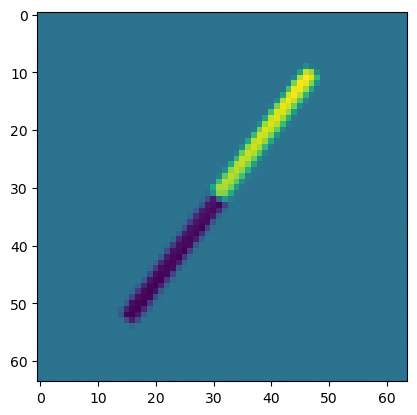

In [8]:
for batch in training_generator:
    break

plt.imshow(batch[0][0][0])
batch[1]

In [9]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    #loss_fn = nn.L1Loss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [27]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1  = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1)
        self.bn1    = nn.BatchNorm2d(8)
        self.conv2  = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.bn2    = nn.BatchNorm2d(16)
        self.pool   = nn.MaxPool2d(2,2)
        self.conv4  = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.bn4    = nn.BatchNorm2d(32)
        self.conv5  = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.bn5    = nn.BatchNorm2d(64)
        self.fc1    = nn.Linear(64*26*26, 1)

    def forward(self, input):
        output = torch.tanh(self.bn1(self.conv1(input)))      
        output = torch.tanh(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = torch.tanh(self.bn4(self.conv4(output)))     
        output = torch.tanh(self.bn5(self.conv5(output))) 
        #print(output.shape)
        output = output.view(-1, 64*26*26)
        output = self.fc1(output)
        output = torch.tanh(output)

        return output

torch.set_default_tensor_type(torch.DoubleTensor)
model = Network()
no_of_params(model)

111269

In [29]:
#model(torch.randn(32,1,64,64)).shape, batch[1].shape

In [38]:
lr = 1e-7
wd = 1e-3
model = Network()

epochs = 1000
optimizer = torch.optim.Adam(
        model.parameters(),
        lr           = lr,
        weight_decay = wd,
    )

gamma = 0.998
scheduler = lr_scheduler.ExponentialLR(
    optimizer, 
    gamma     = gamma)

train_losses = []
val_losses   = []
lrs          = []
for epoch in range(epochs):
    train_loss = train_one_epoch(model,optimizer)
    val_loss   = validate_one_epoch(model,optimizer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #optimizer.step()
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])
    scheduler.step()
    print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,6), " Val loss: ",round(val_loss,6), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

EPOCH:  1  Train loss:  0.098527  Val loss:  0.063666  LR:  9.98e-08
EPOCH:  2  Train loss:  0.058186  Val loss:  0.037468  LR:  9.96e-08
EPOCH:  3  Train loss:  0.036511  Val loss:  0.027377  LR:  9.94e-08
EPOCH:  4  Train loss:  0.026168  Val loss:  0.027219  LR:  9.92e-08
EPOCH:  5  Train loss:  0.025329  Val loss:  0.029922  LR:  9.9e-08
EPOCH:  6  Train loss:  0.026116  Val loss:  0.030572  LR:  9.88e-08
EPOCH:  7  Train loss:  0.025289  Val loss:  0.028406  LR:  9.86e-08
EPOCH:  8  Train loss:  0.023015  Val loss:  0.024853  LR:  9.84e-08
EPOCH:  9  Train loss:  0.019786  Val loss:  0.02152  LR:  9.82e-08
EPOCH:  10  Train loss:  0.019274  Val loss:  0.021468  LR:  9.8e-08
EPOCH:  11  Train loss:  0.021507  Val loss:  0.024983  LR:  9.78e-08
EPOCH:  12  Train loss:  0.026319  Val loss:  0.029576  LR:  9.76e-08
EPOCH:  13  Train loss:  0.030054  Val loss:  0.031377  LR:  9.74e-08
EPOCH:  14  Train loss:  0.030335  Val loss:  0.029606  LR:  9.72e-08
EPOCH:  15  Train loss:  0.02689

EPOCH:  119  Train loss:  0.037047  Val loss:  0.028017  LR:  7.88e-08
EPOCH:  120  Train loss:  0.014383  Val loss:  0.007451  LR:  7.86e-08
EPOCH:  121  Train loss:  0.011144  Val loss:  0.02251  LR:  7.85e-08
EPOCH:  122  Train loss:  0.034229  Val loss:  0.042091  LR:  7.83e-08
EPOCH:  123  Train loss:  0.039011  Val loss:  0.02998  LR:  7.82e-08
EPOCH:  124  Train loss:  0.018336  Val loss:  0.007638  LR:  7.8e-08
EPOCH:  125  Train loss:  0.008531  Val loss:  0.013288  LR:  7.79e-08
EPOCH:  126  Train loss:  0.025691  Val loss:  0.036645  LR:  7.77e-08
EPOCH:  127  Train loss:  0.042747  Val loss:  0.042299  LR:  7.75e-08
EPOCH:  128  Train loss:  0.032203  Val loss:  0.017458  LR:  7.74e-08
EPOCH:  129  Train loss:  0.008763  Val loss:  0.004286  LR:  7.72e-08
EPOCH:  130  Train loss:  0.011733  Val loss:  0.023798  LR:  7.71e-08
EPOCH:  131  Train loss:  0.035082  Val loss:  0.046042  LR:  7.69e-08
EPOCH:  132  Train loss:  0.041106  Val loss:  0.034931  LR:  7.68e-08
EPOCH:  1

EPOCH:  236  Train loss:  0.018916  Val loss:  0.014571  LR:  6.23e-08
EPOCH:  237  Train loss:  0.011933  Val loss:  0.009778  LR:  6.22e-08
EPOCH:  238  Train loss:  0.011004  Val loss:  0.01258  LR:  6.21e-08
EPOCH:  239  Train loss:  0.015438  Val loss:  0.017236  LR:  6.2e-08
EPOCH:  240  Train loss:  0.018179  Val loss:  0.017363  LR:  6.18e-08
EPOCH:  241  Train loss:  0.014802  Val loss:  0.011498  LR:  6.17e-08
EPOCH:  242  Train loss:  0.008859  Val loss:  0.006978  LR:  6.16e-08
EPOCH:  243  Train loss:  0.007145  Val loss:  0.009304  LR:  6.15e-08
EPOCH:  244  Train loss:  0.013058  Val loss:  0.017404  LR:  6.14e-08
EPOCH:  245  Train loss:  0.020331  Val loss:  0.023042  LR:  6.12e-08
EPOCH:  246  Train loss:  0.023173  Val loss:  0.022051  LR:  6.11e-08
EPOCH:  247  Train loss:  0.01875  Val loss:  0.015923  LR:  6.1e-08
EPOCH:  248  Train loss:  0.013288  Val loss:  0.01184  LR:  6.09e-08
EPOCH:  249  Train loss:  0.012334  Val loss:  0.0131  LR:  6.07e-08
EPOCH:  250  

EPOCH:  353  Train loss:  0.002521  Val loss:  0.002144  LR:  4.93e-08
EPOCH:  354  Train loss:  0.002976  Val loss:  0.003717  LR:  4.92e-08
EPOCH:  355  Train loss:  0.004957  Val loss:  0.005135  LR:  4.91e-08
EPOCH:  356  Train loss:  0.004946  Val loss:  0.003803  LR:  4.9e-08
EPOCH:  357  Train loss:  0.003465  Val loss:  0.003173  LR:  4.89e-08
EPOCH:  358  Train loss:  0.00375  Val loss:  0.004896  LR:  4.88e-08
EPOCH:  359  Train loss:  0.005671  Val loss:  0.006451  LR:  4.87e-08
EPOCH:  360  Train loss:  0.005694  Val loss:  0.005324  LR:  4.86e-08
EPOCH:  361  Train loss:  0.003656  Val loss:  0.002922  LR:  4.85e-08
EPOCH:  362  Train loss:  0.002847  Val loss:  0.00323  LR:  4.84e-08
EPOCH:  363  Train loss:  0.004352  Val loss:  0.00484  LR:  4.83e-08
EPOCH:  364  Train loss:  0.005023  Val loss:  0.004224  LR:  4.83e-08
EPOCH:  365  Train loss:  0.003727  Val loss:  0.002636  LR:  4.82e-08
EPOCH:  366  Train loss:  0.002715  Val loss:  0.003031  LR:  4.81e-08
EPOCH:  36

EPOCH:  469  Train loss:  0.003683  Val loss:  0.003128  LR:  3.91e-08
EPOCH:  470  Train loss:  0.00218  Val loss:  0.001142  LR:  3.9e-08
EPOCH:  471  Train loss:  0.000917  Val loss:  0.00086  LR:  3.89e-08
EPOCH:  472  Train loss:  0.001952  Val loss:  0.002814  LR:  3.89e-08
EPOCH:  473  Train loss:  0.003548  Val loss:  0.003506  LR:  3.88e-08
EPOCH:  474  Train loss:  0.003048  Val loss:  0.002076  LR:  3.87e-08
EPOCH:  475  Train loss:  0.001248  Val loss:  0.000707  LR:  3.86e-08
EPOCH:  476  Train loss:  0.001141  Val loss:  0.001943  LR:  3.86e-08
EPOCH:  477  Train loss:  0.002851  Val loss:  0.003594  LR:  3.85e-08
EPOCH:  478  Train loss:  0.003574  Val loss:  0.003062  LR:  3.84e-08
EPOCH:  479  Train loss:  0.002128  Val loss:  0.001224  LR:  3.83e-08
EPOCH:  480  Train loss:  0.000941  Val loss:  0.001246  LR:  3.83e-08
EPOCH:  481  Train loss:  0.001905  Val loss:  0.002959  LR:  3.82e-08
EPOCH:  482  Train loss:  0.003377  Val loss:  0.003661  LR:  3.81e-08
EPOCH:  4

EPOCH:  585  Train loss:  0.00214  Val loss:  0.002377  LR:  3.1e-08
EPOCH:  586  Train loss:  0.002214  Val loss:  0.001726  LR:  3.09e-08
EPOCH:  587  Train loss:  0.001143  Val loss:  0.000521  LR:  3.09e-08
EPOCH:  588  Train loss:  0.000366  Val loss:  0.000592  LR:  3.08e-08
EPOCH:  589  Train loss:  0.001078  Val loss:  0.001941  LR:  3.08e-08
EPOCH:  590  Train loss:  0.0022  Val loss:  0.0027  LR:  3.07e-08
EPOCH:  591  Train loss:  0.002113  Val loss:  0.001502  LR:  3.06e-08
EPOCH:  592  Train loss:  0.000916  Val loss:  0.000396  LR:  3.06e-08
EPOCH:  593  Train loss:  0.000369  Val loss:  0.000523  LR:  3.05e-08
EPOCH:  594  Train loss:  0.001173  Val loss:  0.001548  LR:  3.04e-08
EPOCH:  595  Train loss:  0.002203  Val loss:  0.002036  LR:  3.04e-08
EPOCH:  596  Train loss:  0.00191  Val loss:  0.001251  LR:  3.03e-08
EPOCH:  597  Train loss:  0.000769  Val loss:  0.000389  LR:  3.03e-08
EPOCH:  598  Train loss:  0.000413  Val loss:  0.000819  LR:  3.02e-08
EPOCH:  599  

EPOCH:  701  Train loss:  0.000324  Val loss:  0.00034  LR:  2.46e-08
EPOCH:  702  Train loss:  0.000548  Val loss:  0.000814  LR:  2.45e-08
EPOCH:  703  Train loss:  0.001078  Val loss:  0.001082  LR:  2.45e-08
EPOCH:  704  Train loss:  0.001071  Val loss:  0.000827  LR:  2.44e-08
EPOCH:  705  Train loss:  0.00059  Val loss:  0.000317  LR:  2.44e-08
EPOCH:  706  Train loss:  0.000312  Val loss:  0.000392  LR:  2.43e-08
EPOCH:  707  Train loss:  0.000601  Val loss:  0.001016  LR:  2.43e-08
EPOCH:  708  Train loss:  0.001104  Val loss:  0.001408  LR:  2.42e-08
EPOCH:  709  Train loss:  0.001096  Val loss:  0.000892  LR:  2.42e-08
EPOCH:  710  Train loss:  0.000536  Val loss:  0.000321  LR:  2.41e-08
EPOCH:  711  Train loss:  0.000254  Val loss:  0.000354  LR:  2.41e-08
EPOCH:  712  Train loss:  0.000602  Val loss:  0.000836  LR:  2.4e-08
EPOCH:  713  Train loss:  0.001136  Val loss:  0.001148  LR:  2.4e-08
EPOCH:  714  Train loss:  0.001022  Val loss:  0.000664  LR:  2.39e-08
EPOCH:  71

EPOCH:  817  Train loss:  0.000277  Val loss:  0.000215  LR:  1.95e-08
EPOCH:  818  Train loss:  0.000189  Val loss:  0.000244  LR:  1.94e-08
EPOCH:  819  Train loss:  0.000265  Val loss:  0.000399  LR:  1.94e-08
EPOCH:  820  Train loss:  0.000381  Val loss:  0.000443  LR:  1.94e-08
EPOCH:  821  Train loss:  0.000327  Val loss:  0.000308  LR:  1.93e-08
EPOCH:  822  Train loss:  0.000192  Val loss:  0.000214  LR:  1.93e-08
EPOCH:  823  Train loss:  0.000193  Val loss:  0.000269  LR:  1.93e-08
EPOCH:  824  Train loss:  0.000302  Val loss:  0.000383  LR:  1.92e-08
EPOCH:  825  Train loss:  0.000335  Val loss:  0.000364  LR:  1.92e-08
EPOCH:  826  Train loss:  0.000253  Val loss:  0.000246  LR:  1.91e-08
EPOCH:  827  Train loss:  0.000185  Val loss:  0.00023  LR:  1.91e-08
EPOCH:  828  Train loss:  0.000247  Val loss:  0.000387  LR:  1.91e-08
EPOCH:  829  Train loss:  0.000309  Val loss:  0.000367  LR:  1.9e-08
EPOCH:  830  Train loss:  0.000269  Val loss:  0.000252  LR:  1.9e-08
EPOCH:  8

EPOCH:  933  Train loss:  0.000133  Val loss:  0.000156  LR:  1.54e-08
EPOCH:  934  Train loss:  0.000125  Val loss:  0.000153  LR:  1.54e-08
EPOCH:  935  Train loss:  0.000142  Val loss:  0.000169  LR:  1.54e-08
EPOCH:  936  Train loss:  0.000143  Val loss:  0.000155  LR:  1.54e-08
EPOCH:  937  Train loss:  0.000127  Val loss:  0.000153  LR:  1.53e-08
EPOCH:  938  Train loss:  0.000123  Val loss:  0.000181  LR:  1.53e-08
EPOCH:  939  Train loss:  0.000136  Val loss:  0.000174  LR:  1.53e-08
EPOCH:  940  Train loss:  0.000141  Val loss:  0.00016  LR:  1.52e-08
EPOCH:  941  Train loss:  0.000119  Val loss:  0.00014  LR:  1.52e-08
EPOCH:  942  Train loss:  0.000125  Val loss:  0.00015  LR:  1.52e-08
EPOCH:  943  Train loss:  0.000145  Val loss:  0.000163  LR:  1.51e-08
EPOCH:  944  Train loss:  0.000129  Val loss:  0.000147  LR:  1.51e-08
EPOCH:  945  Train loss:  0.000126  Val loss:  0.00016  LR:  1.51e-08
EPOCH:  946  Train loss:  0.000137  Val loss:  0.000215  LR:  1.5e-08
EPOCH:  947

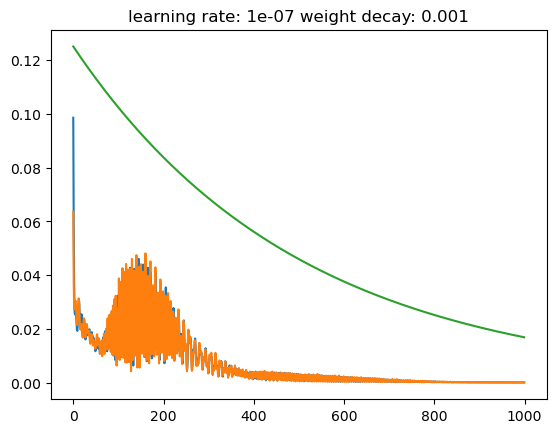

In [39]:
txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
plt.title(txt)
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot( [lr/8e-7 for lr in lrs ])
plt.show()

0.735783929500595


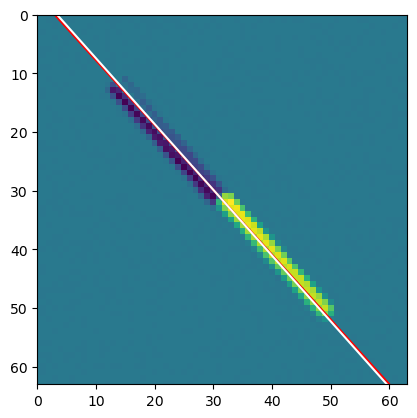

2.603488229694302


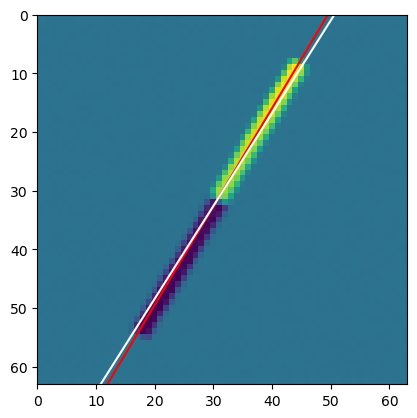

0.1985559022814779


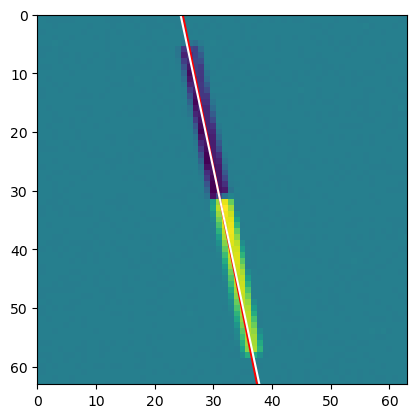

3.0798661163161727


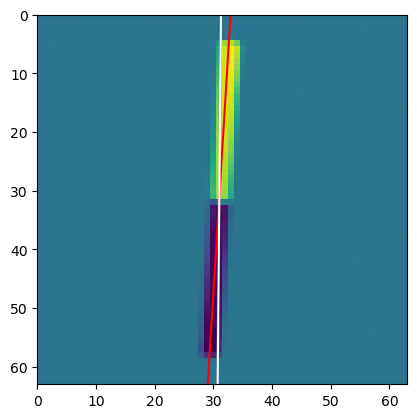

1.4260384928628616


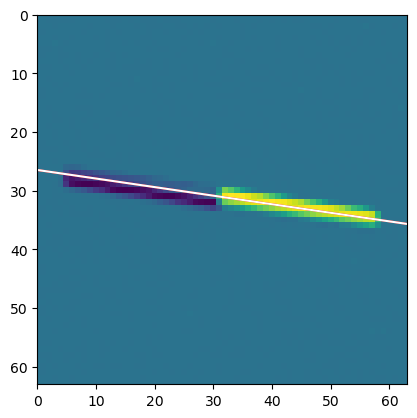

0.5229603683479775


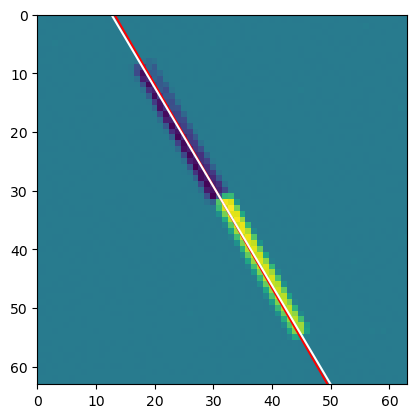

1.1885148198630262


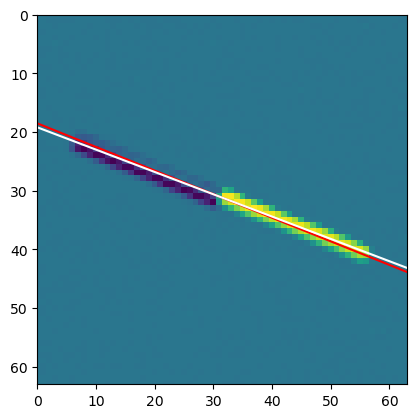

0.9264961712253549


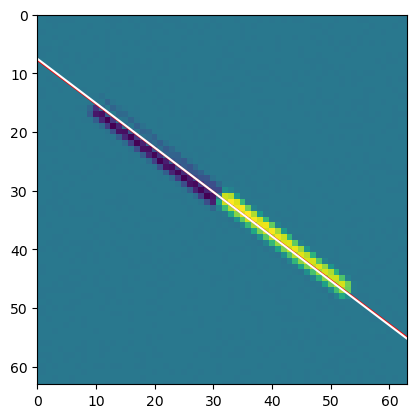

1.3238688416350373


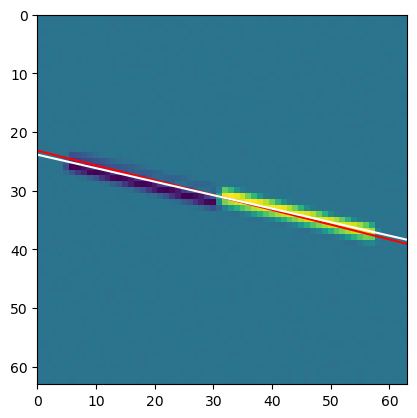

2.219772706600314


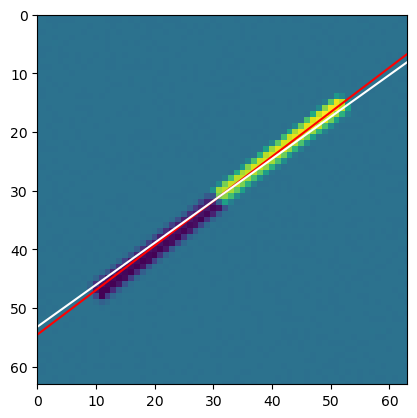

2.7408880078551054


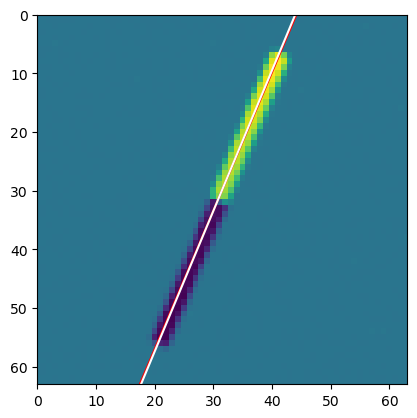

1.3875988138269


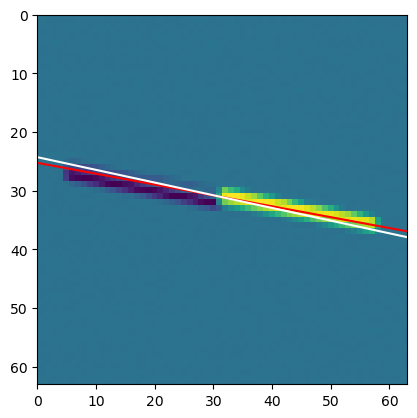

1.3216953079264022


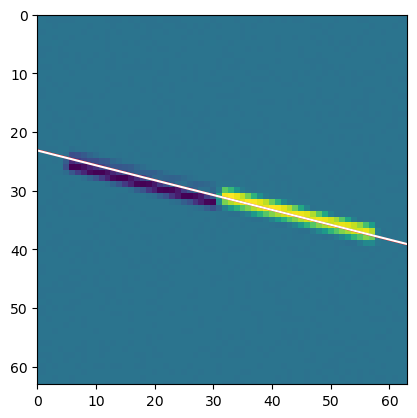

1.0451233358838792


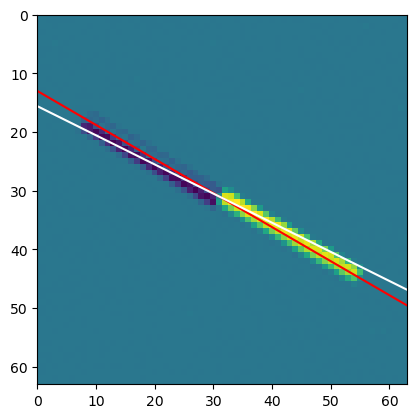

1.09331156946906


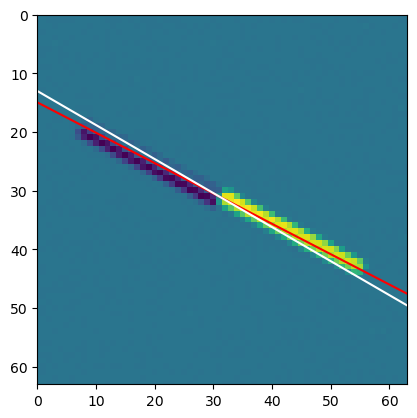

2.481948539368716


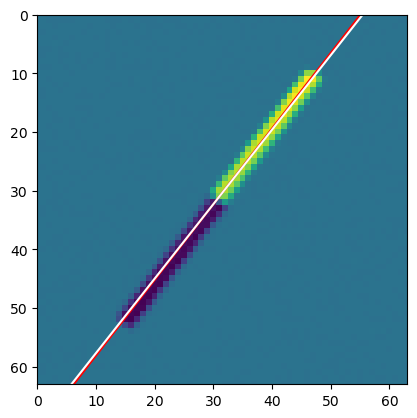

2.838121894358094


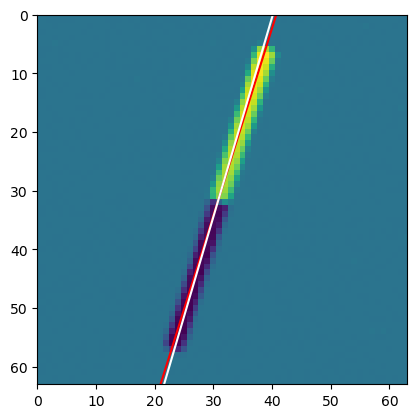

2.5502108385017483


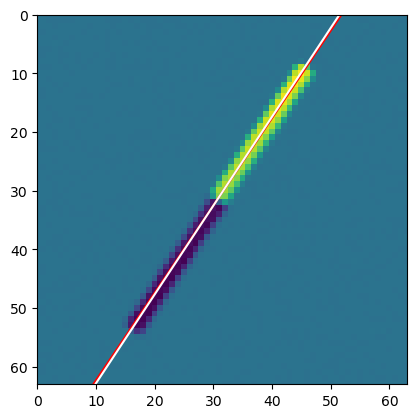

2.1742475367358


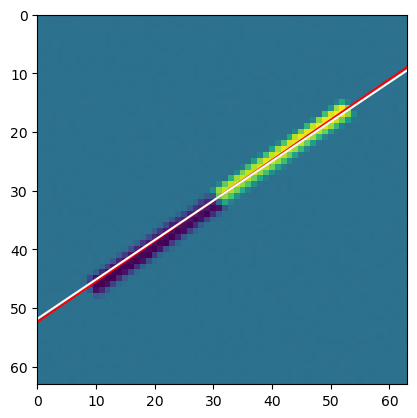

1.0426540687380614


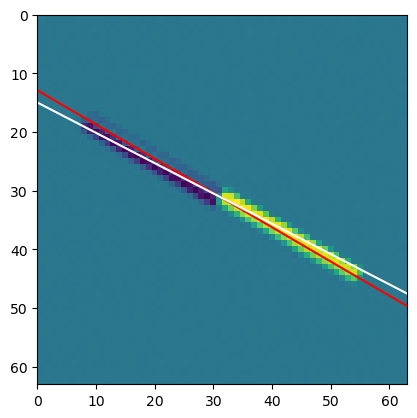

1.9091828390973056


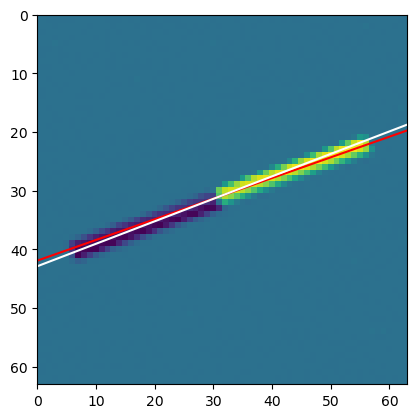

2.527786121172196


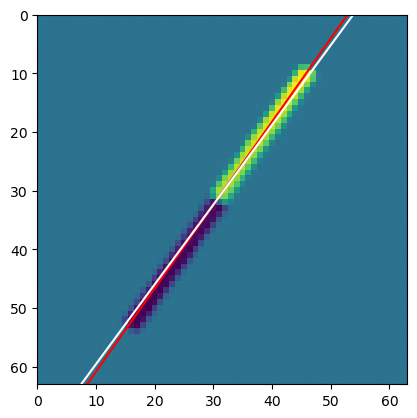

0.5193740797341592


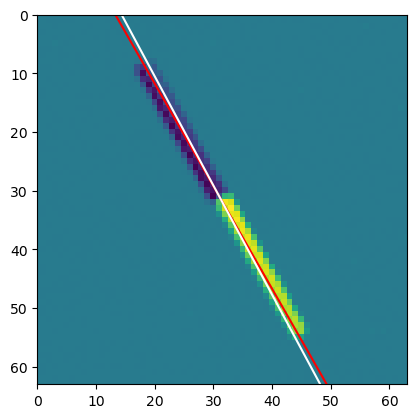

0.8058236332080395


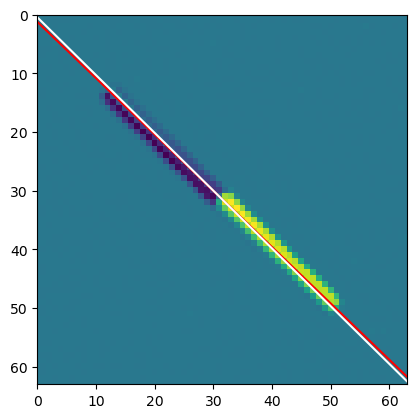

0.9990725143943469


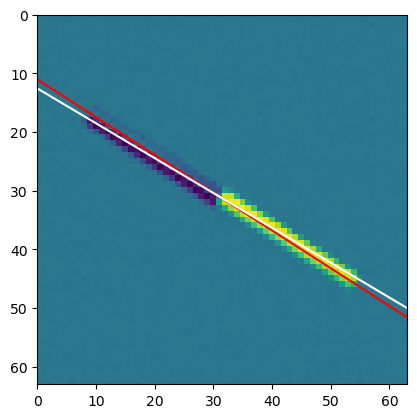

2.9789063847288695


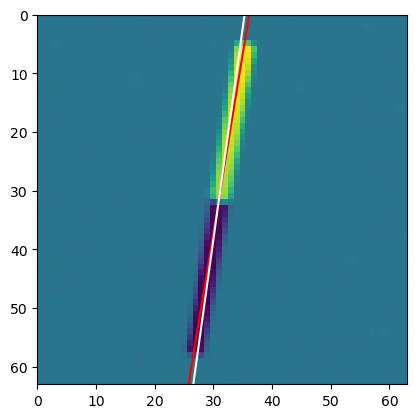

1.0410773477716728


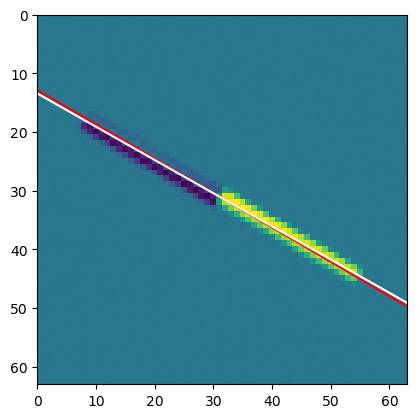

2.938800575003728


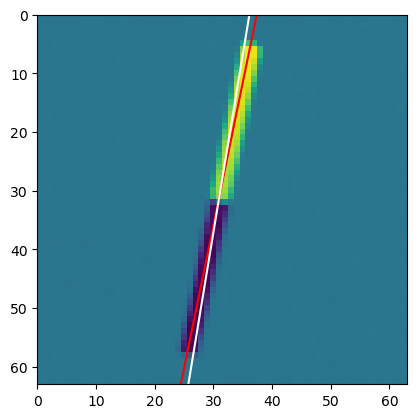

0.6461421267461868


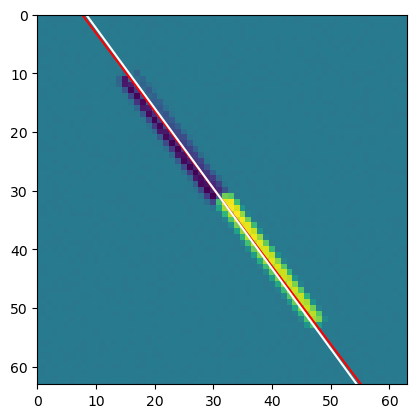

2.878493689543058


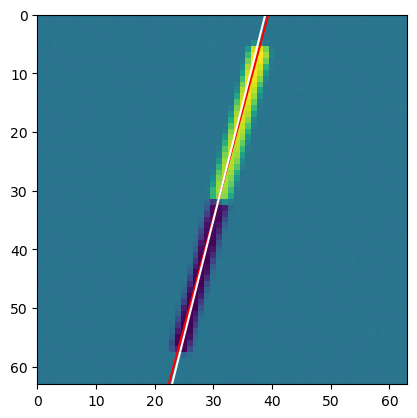

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Anaconda\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Anaconda\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Anaconda\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Anaconda\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelector

In [42]:
test_IDs = [ random.randint(0,999) for i in range(100) ]

real = []
outputs = []
for ID in test_IDs[:30]:
    input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_6/images/"
    label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_6/labels/"
    
    X = torchvision.io.read_image(
                input_dir + str(ID) + ".png "
            ).to(torch.float64)
    plt.imshow(X[1])
    X = X/256.
    
    with open(label_dir + str(ID), 'rb') as fb:
        Y  = pickle.load(fb)
        Y = Y[1][0]#/3.1415926
        
    #Y = Y + 0.5
        
    output = (float(model(X[1].unsqueeze(0).unsqueeze(0))) + 0.5 )*3.1415926
    print(Y)
    
    real.append(Y)
    outputs.append(output)
    
    #plt.plot( [16 - 50*math.tan(Y),16 ,16 + 50*math.tan(Y)],[16 - 50, 16,16 + 50], c='r')
    plt.plot( [31 - 50*math.tan(Y),31 ,31 + 50*math.tan(Y)],[31 - 50, 31,31 + 50], c='r')
    plt.plot( [31 - 50*math.tan(output),31 ,31 + 50*math.tan(output)],[31 - 50, 31,31 + 50], c='w')
    
    plt.xlim(0,63)
    plt.ylim(63,0)
    
    
    #plt.axvline( x = (Y + 1)*16, c='w' )
    #plt.axvline( x = (output + 1.)*16, c='r')
    plt.show()
    
        